In [13]:
%matplotlib inline
import sys
from collections import defaultdict,deque

if "../" not in sys.path:
    sys.path.append("../")
    
import numpy as np
from lib.envs.GridEnv import Env
from lib.utils.draw import show_grid,show_policy,draw_line
import matplotlib

env = Env( (20, 20),p=0.4,seed=5,punish=-100)

In [14]:
def get_epsilon_policy(Q,nA,num_episodes):
    
    # 逐渐递减的 eps
    explore_frac = 0.1
    epsilon = lambda i: 1 - 0.99 * min(1, i / (num_episodes * explore_frac))

    def policy_fn(observation,i_episode):
        # eps = epsilon(i_episode)
        eps = 0.1
        A = np.ones(nA) * eps / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1 - eps)
        return A
    return policy_fn

In [15]:
def get_action(policy,state,i_episode):
    probs = policy(state,i_episode)
    action = np.random.choice(range(len(probs)), p=probs)
    return action

In [16]:
def n_step_Sarsa(env,n,num_episodes,gamma=0.9,alpha =0.1):
    
    # initial Q(s,a), ExpReplayBuffer,policy
    Q = np.zeros( (env.observation_size,env.action_size) )
    policy = get_epsilon_policy(Q,env.action_size,num_episodes)
    # ExpReplayBuffer
    Exp = deque([],maxlen=n)
    
    # stats for output
    stats = defaultdict(lambda: [])
    last_step = 0
    for i_episode in range(num_episodes):
        if i_episode % 10 == 0:
            #\r 实现动态更新
            print(f"\r Episode :{i_episode/num_episodes * 100:.2f}%  last step: {last_step:4}",end = "")
            sys.stdout.flush()
        # reset stats param
        last_step = 0
        total_reward = 0
        
        # initial game
        state = env.reset()
        action = get_action(policy,state,i_episode)
        T,t = 0x3f3f3f3f,0 
        while True:
            
            if t < T:
                next_state,reward,done = env.step(action)
                next_action = get_action(policy,next_state,i_episode)
                Exp.append( (state,action,reward,next_state,next_action) ) # S A R S A
                # stats update
                total_reward += reward
                last_step += 1
                if done:
                    T = t + 1
                    
                # update
                state, action = next_state,next_action
                
            tau = t - n + 1
            if tau >= 0:
                start = 0 if tau + n < T  else t - T
                G = 0
                for i_exp in range(start,1,n):
                    exp_r = Exp[i_exp][2]
                    G = G + exp_r * gamma
                
                if tau + n < T:
                    G += (gamma ** n) * Q[ Exp[-1][3] ][ Exp[-1][4] ]
                now_start,now_action = Exp[start][0], Exp[start][1]
                Q[now_start][now_action] += alpha * (G - Q[now_start][now_action])
                #print(Exp)
            t += 1
            
            if tau == T - 1 :
                break
        stats['rewards'].append(total_reward)
        stats['steps'].append(last_step)
            
    return Q,stats
    

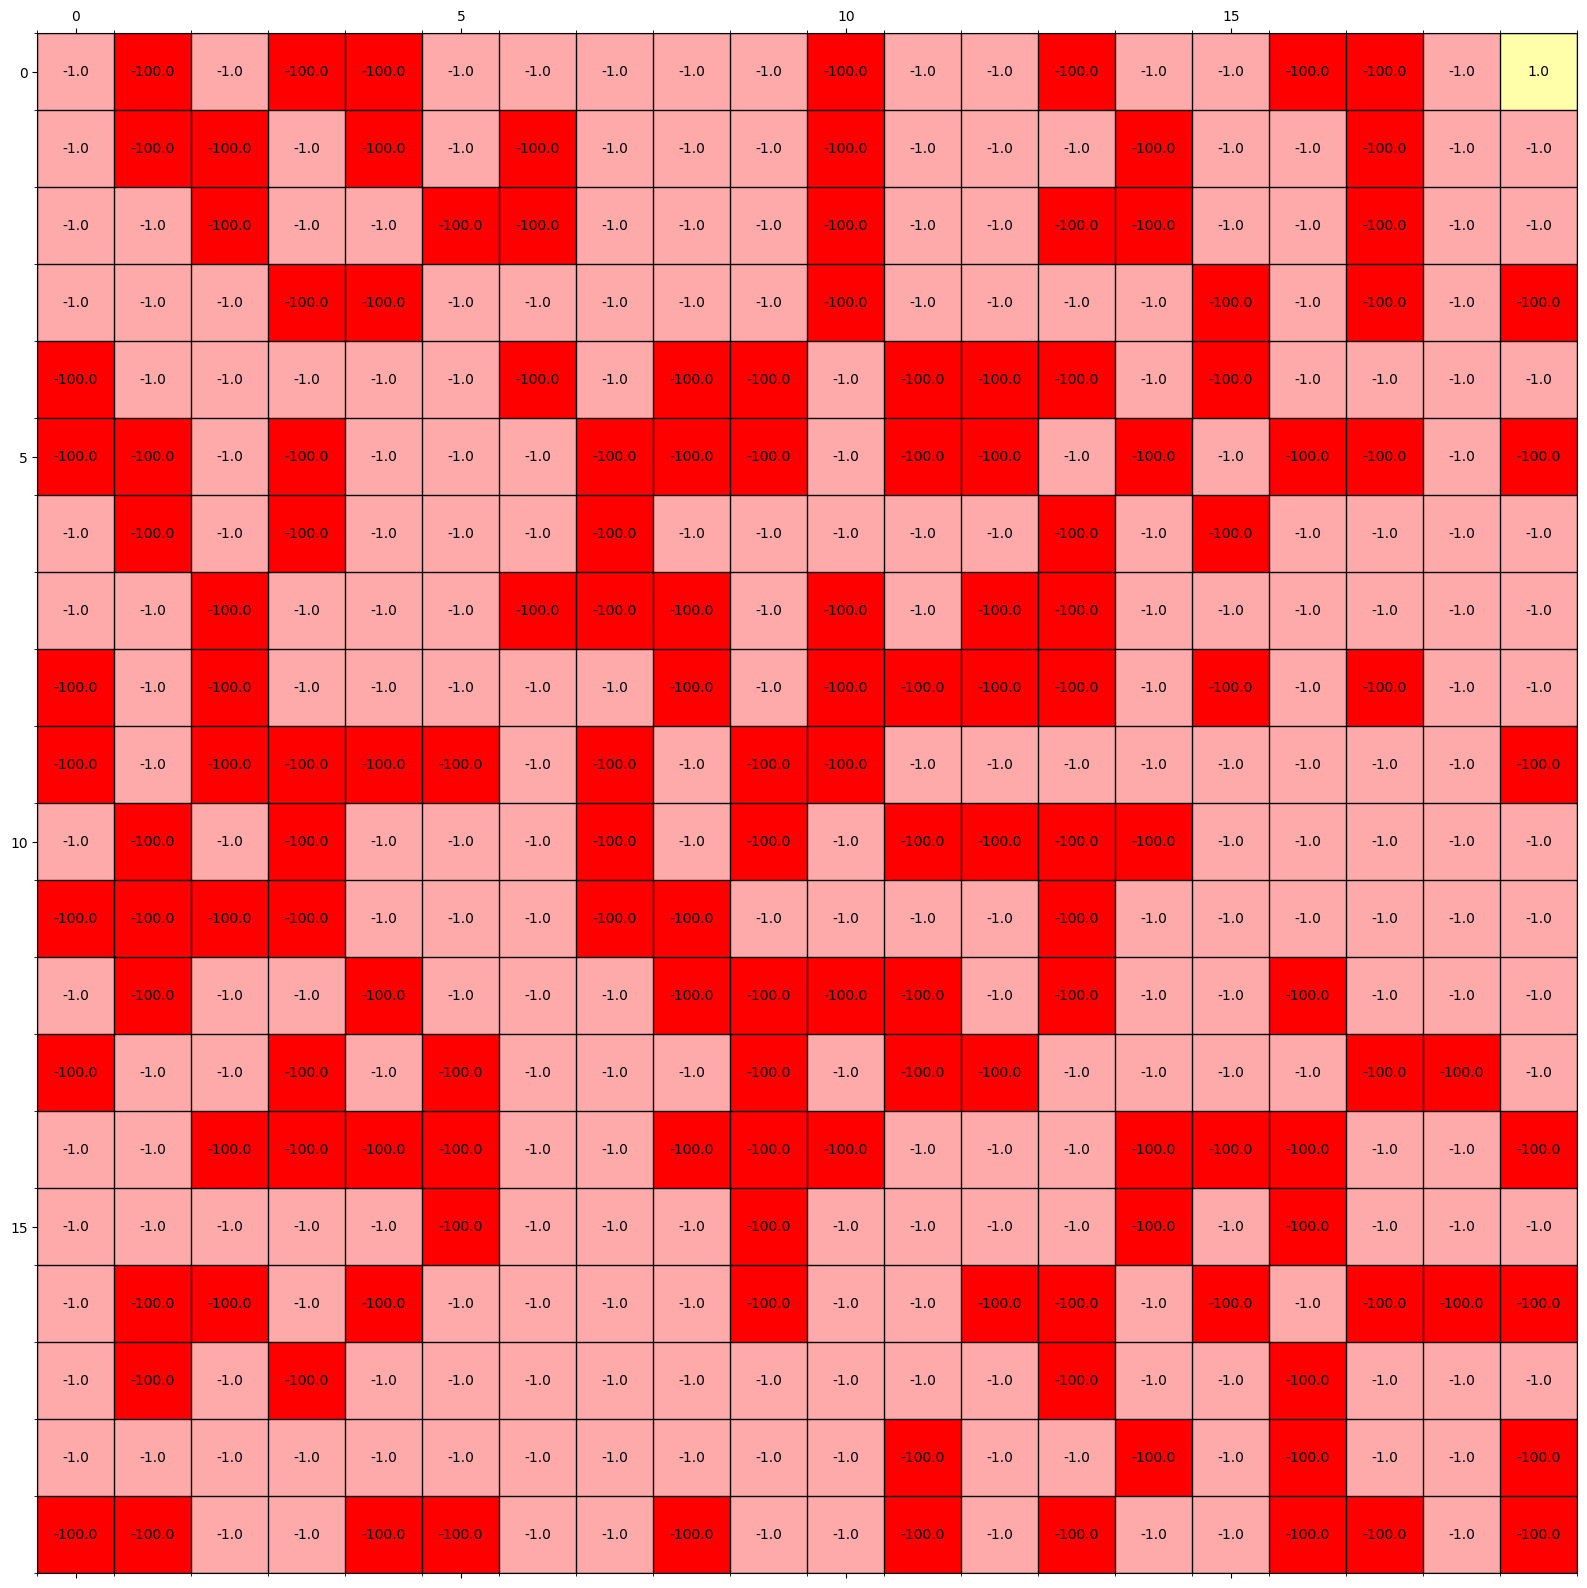

 Episode :99.00%  last step:  315

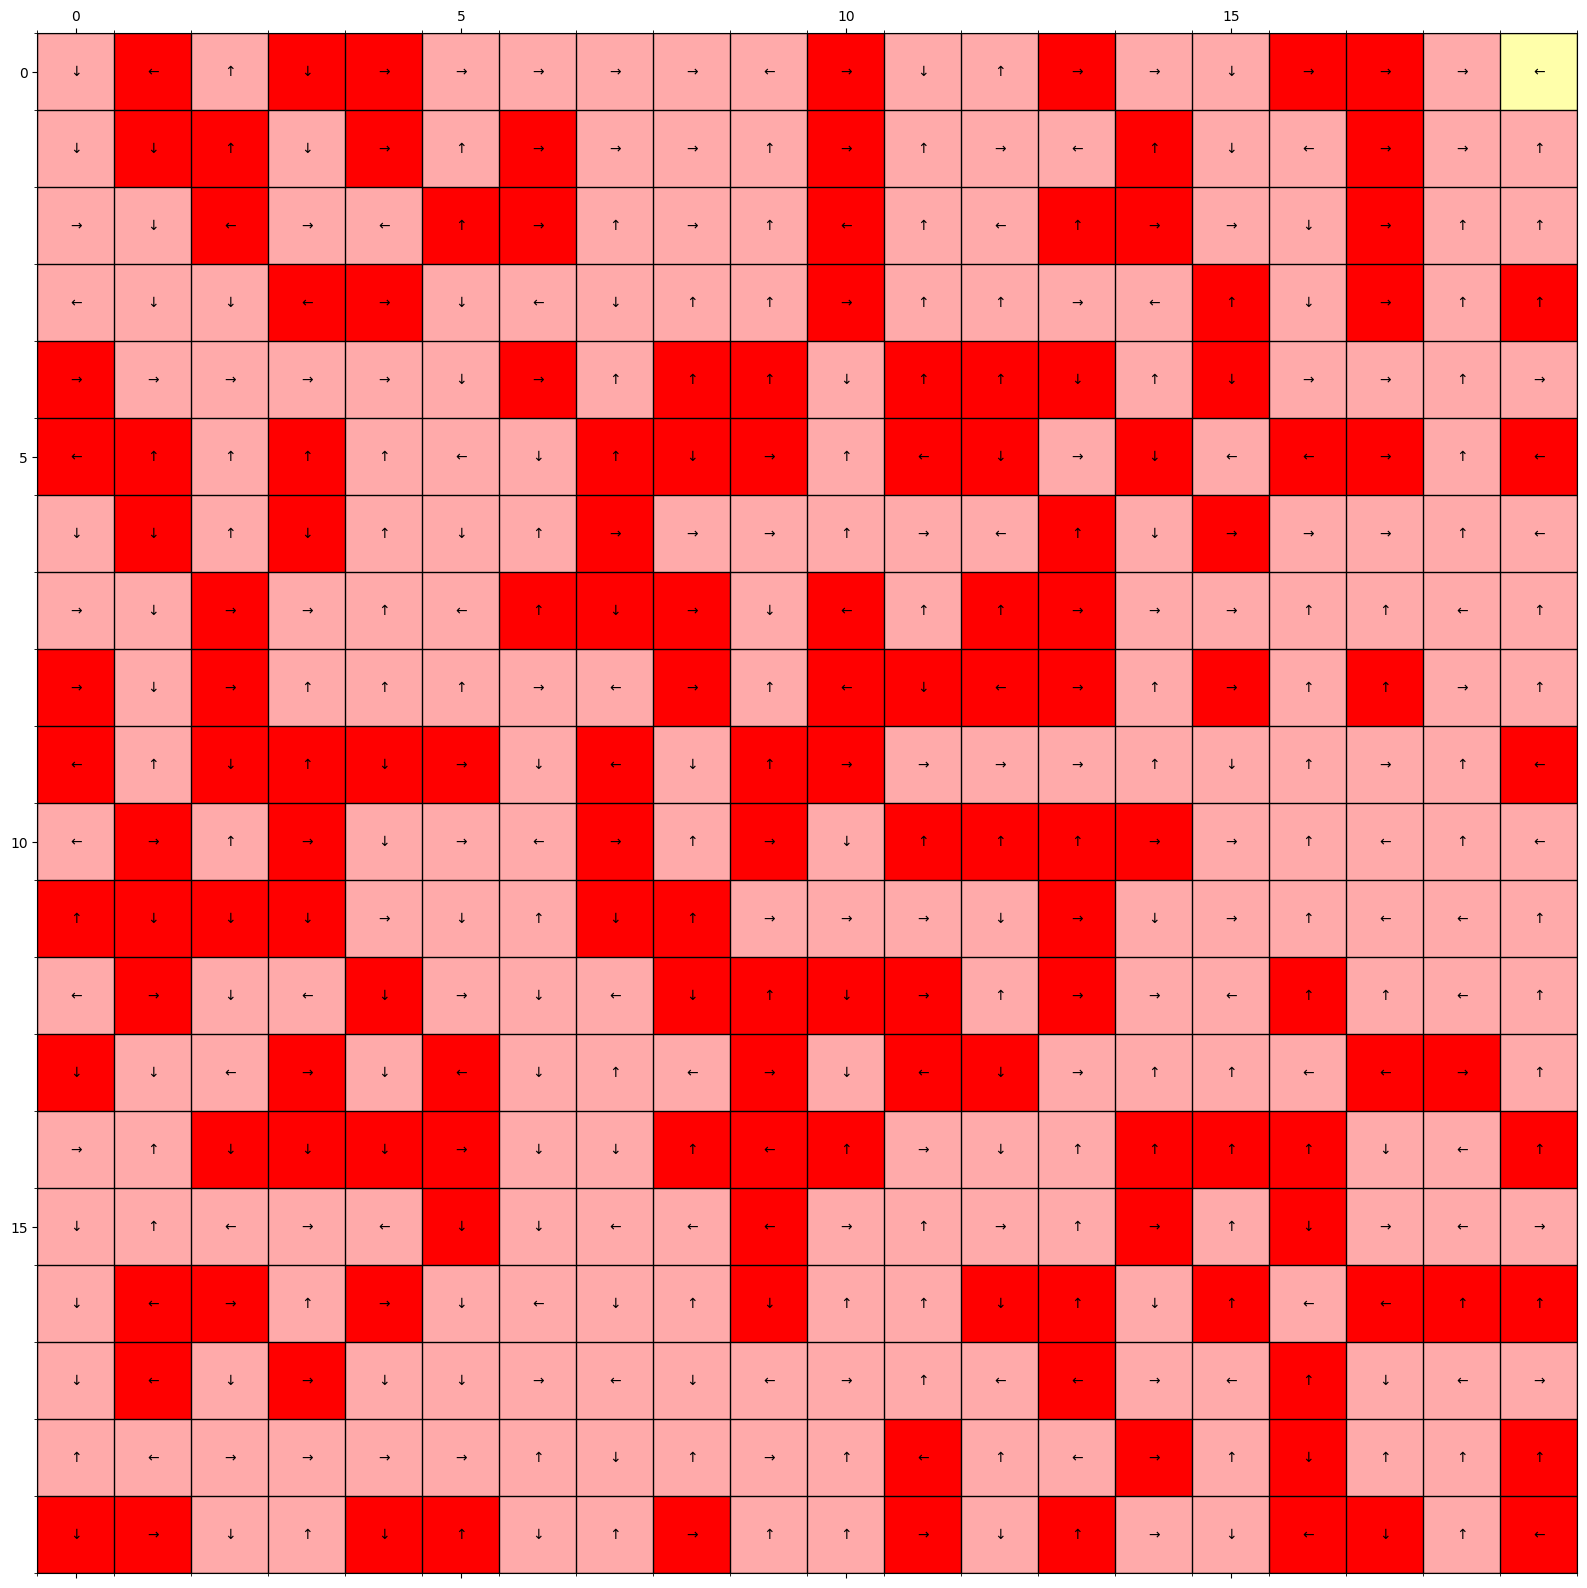

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

In [17]:
show_grid(env,env.grid)
num_episodes = 1000
Q,stats = n_step_Sarsa(env,4,num_episodes=num_episodes,gamma=0.99,alpha=0.1)
V = np.zeros( env.observation_size )
policy = np.zeros_like(Q)
for i in range(len(V)):
    best_action = np.argmax(Q[i])
    V[i] = Q[i][best_action]
    policy[i][best_action] = 1
show_policy(env,policy)
draw_line(stats)


In [ ]:
show_grid(env,V)

In [ ]:
a = [1,2,3,4,5,6]
print(a[-8:])